<h3>Linear regression lab 2</h3>


#### Aims 

* Practice general linear regression with polynomial and RBF 
* Choose the order of polynomials with cross validation
* Practice ridge regression


#### Tasks 
* Rescale
* Write functions to construct the design matrix, $X$, with polynomials and RBFs
* Implement cross-validation to choose the right polynoimal order
* Test polynoimal regression and cross-validation on new data where the true order is known
* Test ridge regression
* Test linear regression with the RBF

#### Task 1: Again, we start by loading the Olympic 100m men's data

In [1]:
import numpy as np 
%matplotlib inline
import pylab as plt

data = np.loadtxt('olympic100m.txt', delimiter=',') # make sure olympic100m.txt is in the right folder
x = data[:,0][:,None] # make x a matrix
t = data[:,1][:,None] # make t a column vector 
print(t.shape)

(27, 1)


#### Task 2: Perform Polynomial Regression on the Olympic data

#### Task 2.1 Rescale $x$ 
We rescale $x$ to make it small. Doing so will stablise the computatoin, otherwise it quickly becomes unfeasible to fit polynomials over ~$2000$. Let's test the following two options:
- Option 1: `(x-1896)/40`
- Option 2: `(x-np.mean(x))/np.std(x) `

In [2]:
def transform(x):
    return   (x-np.mean(x))/np.std(x)# copy the code above to perform different rescaling

Text(0, 0.5, 'Time (seconds)')

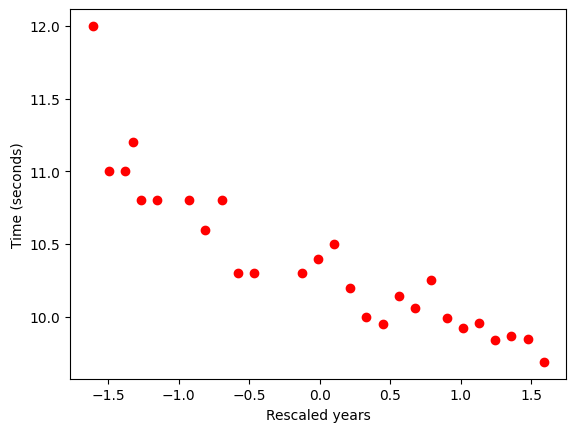

In [3]:
# Test both options
x = transform(x)# rescale x here
plt.plot(x, t, 'ro')
plt.xlabel('Rescaled years')
plt.ylabel('Time (seconds)')

#### Task 2.2 Write you own function to construct the design matrix with polynomials

$$\mathbf{X} = \begin{bmatrix}
    1       & x_{1} & x_{1}^2 & \dots & x_{1}^K \\
    1       & x_{2} & x_{2} & \dots & x_{2}^K \\
    \vdots & \vdots &\vdots &\ddots &\vdots\\
    1       & x_{N} & x_{N}^2 & \dots & x_{N}^K
\end{bmatrix} $$

In [4]:
def make_polynomial(x, maxorder): # The np.hstack function can be very helpful
    temp = [x ** k  for k in range(maxorder + 1)]
    X = np.hstack(temp)
    return(X) 

#### Task 2.3 Construct the design matrix with a predefined maximum polynomial order 

In [5]:

poly_order = 9
X_train = make_polynomial(x, poly_order) 


#### Task 2.4 Fit a linear regression model with polynomial matrix and print out the training loss

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, t)
t_pred = model.predict(X_train)
mse = np.mean((t-t_pred) ** 2)
# Fit a linear model
print('loss at order ', poly_order, ' :', mse)

loss at order  9  : 0.015317351464102982


#### Task 2.5 Plot the fitted model and data

Text(0, 0.5, 'Time (seconds)')

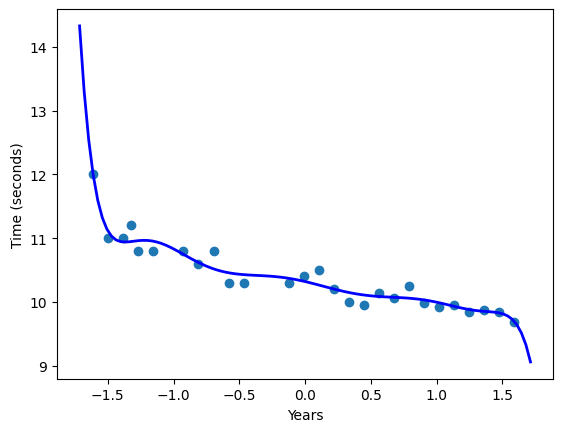

In [7]:
x_test = np.linspace(1880, 2020, 100).reshape(-1,1) # test data
x_test = transform(x_test) # do the same rescaling to the test data 
X_test = make_polynomial(x_test, poly_order) # construct the polynomial matrix for test data
f_test = model.predict(X_test)
plt.plot(x_test,f_test,'b-',linewidth=2) # plot the fitted data
plt.scatter(x,t) # draw a scatter plot
plt.xlabel('Years') # always label x&y-axis
plt.ylabel('Time (seconds)') # always label x&y-axis

### Task 3: Choosing Polynomial order with Cross-Validation

#### Task 3.1: Cross-Validation with a given Polynomial order.
Reference for `KFold`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [8]:
from sklearn.model_selection import KFold 
cv = KFold(n_splits = 5) # call KFold to set up CV 
loss = [] # initiate a set to collect loss
reg =  LinearRegression() # call a linear regression model

poly_order = 9 
X_train = make_polynomial(x, poly_order)

for train_index, test_index in cv.split(X_train): 
    print('TRAIN:', train_index, 'TEST:', test_index)
    
    X_train_fold = X_train[train_index]
    X_test_fold = X_train[test_index] # select X for training and testing
    
    t_train_fold = t[train_index]
    t_test_fold = t[test_index] # select t for training and testing
    
    reg.fit(X_train_fold, t_train_fold) # fit a model on the training data 
    
    loss.append(np.mean((reg.predict(X_test_fold) - t_test_fold) ** 2)) # compute loss on test data
print(loss) # print loss across fold
print(np.mean(loss)) # print average loss at this polynomial order

TRAIN: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26] TEST: [0 1 2 3 4 5]
TRAIN: [ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26] TEST: [ 6  7  8  9 10 11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 17 18 19 20 21 22 23 24 25 26] TEST: [12 13 14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 22 23 24 25 26] TEST: [17 18 19 20 21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22 23 24 25 26]
[np.float64(2331.177225272375), np.float64(0.4133916880375062), np.float64(0.03962632115541264), np.float64(0.13148255026635208), np.float64(107.12933254068062)]
487.7782116745029


#### Task 3.2: Cross-Validation for a range of Polynomial orders.

Text(0, 0.5, 'Log Loss')

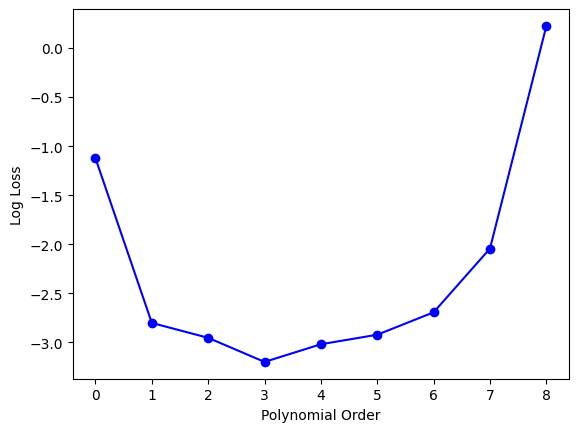

In [9]:
cv = KFold(n_splits = 10) # call KFold to set up CV 
reg = LinearRegression() # call a linear regression model
all_loss = [] # initiate a set to collect loss

for i in range(9):  # 1st for loop over polynomial orders 
    poly_order = i
    X_train = make_polynomial(x, poly_order) 
    loss_at_order = [] # initiate a set to collect loss for CV
    for train_index, test_index in cv.split(X_train): # 2nd for loop for cross-validation
        X_train_fold = X_train[train_index]
        X_test_fold = X_train[test_index] # select X for training and testing
        t_train_fold = t[train_index]
        t_test_fold = t[test_index]  # select t for training and testing
        reg.fit(X_train_fold, t_train_fold)# fit a model on the training data 
        loss_at_order.append(np.mean( (t_test_fold - reg.predict(X_test_fold)) ** 2)) # collect loss at fold
    all_loss.append(loss_at_order) # collect loss at order
mean_losses = [np.mean(losses) for losses in all_loss]
plt.plot(range(9), np.log(mean_losses), 'bo-') # plot log(loss) at order
plt.xlabel('Polynomial Order') # always label x&y-axis
plt.ylabel('Log Loss') # always label x&y-axis

### Task 4: Cross-Validation for Polynomial order on new data

In [10]:
np.random.seed(1) # fix random seed such that every time we get the same random numbers

N = 100 # total number of data points 
x = 10*np.random.rand(N,1) - 5 # generate random x
t = 5*x**3 - x**2 + x + 200*np.random.randn(N,1) # generate t according to the true model with additive noise

N_independent_test = 50 # total number of independent testing data points 
x_independent_test = 10*np.random.rand(N_independent_test,1) - 5 # generate independent testing x
t_independent_test = 5*x_independent_test**3 - x_independent_test**2 + x_independent_test + 200*np.random.randn(N_independent_test,1) # generate independent testing t with noise

### Plot new data.

Text(0, 0.5, 't')

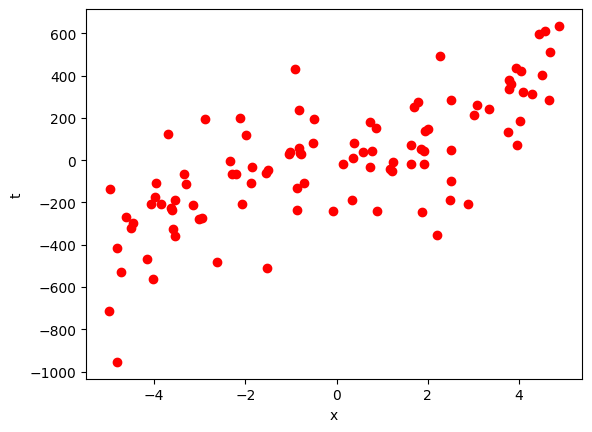

In [11]:
plt.plot(x, t, 'ro')
plt.xlabel('x')
plt.ylabel('t')

#### Task 4.1: Redo Cross-Validation for Polynomial order on new data. Plot CV loss, training loss, and loss on the independent test set

Text(0, 0.5, 'Log Loss')

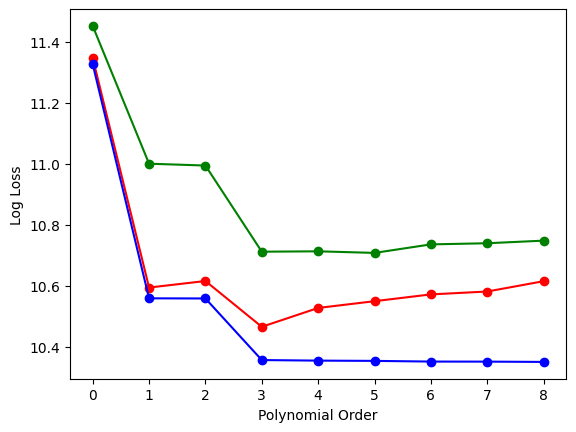

In [12]:
cv = KFold(n_splits = 10)
reg = LinearRegression() # model for CV
reg_train = LinearRegression() # model for loss on training and independent test 

all_loss = []
all_loss_trian = []
all_loss_independent_test = []

for i in range(9):  # 1st for loop over polynomial order
    
    poly_order = i 
    
    X_train = make_polynomial(x, poly_order)  # construct polynomial matrix for all training data
    reg_train.fit(X_train, t) # fit model on all training data
    all_loss_trian.append( np.mean( (reg_train.predict(X_train) - t) ** 2) ) # collect training loss
    
    
    
    X_independent_test = make_polynomial(x_independent_test, poly_order) #construct polynomial matrix for the independent test data
    #reg_train.fit(X_independent_test, t_independent_test)
    
    all_loss_independent_test.append( np.mean( (reg_train.predict(X_independent_test) - t_independent_test) ** 2) )
        # collect loss on independent test data
    
    loss_at_order = [] 
    for train_index, test_index in cv.split(X_train): # 2nd for loop over folds
        
        
        
        X_train_fold = X_train[train_index]
        X_test_fold = X_train[test_index] # select X for training and testing
        
        t_train_fold = t[train_index]
        t_test_fold = t[test_index] # select t for training and testing
        
        reg_train.fit(X_train_fold, t_train_fold)  # fit a model on the training data 
        
        loss_at_order.append( np.mean( (reg_train.predict(X_test_fold) - t_test_fold) ** 2) ) # collect loss at fold
    all_loss.append(np.mean(loss_at_order)) # collect loss at order

plt.plot(np.log(all_loss), 'ro-') 
plt.plot(np.log(all_loss_trian), 'bo-')
plt.plot(np.log(all_loss_independent_test), 'go-')
plt.xlabel('Polynomial Order') # always label x&y-axis
plt.ylabel('Log Loss') # always label x&y-axis

### Task 5: Polynomial Linear Regression with L2 regression.

$$ \hat{\mathbf{w}}_{ridge} = \underset{\mathbf{w} }{\mathrm{argmin}}
 \frac{1}{N} (\mathbf{t} - \mathbf{X}\mathbf{w} )^{T} (\mathbf{t} - \mathbf{X}\mathbf{w} ) + \alpha \mathbf{w}^T \mathbf{w}$$
check out https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html for `Ridge`
check out https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html for `GridSearchCV`

D:\miniconda\envs\Python_env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.06158e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\miniconda\envs\Python_env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.65189e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\miniconda\envs\Python_env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.71183e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\miniconda\envs\Python_env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.26802e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\miniconda\envs\Python_env\lib\site-packages\sklearn\linea

Text(0, 0.5, 'Time (seconds)')

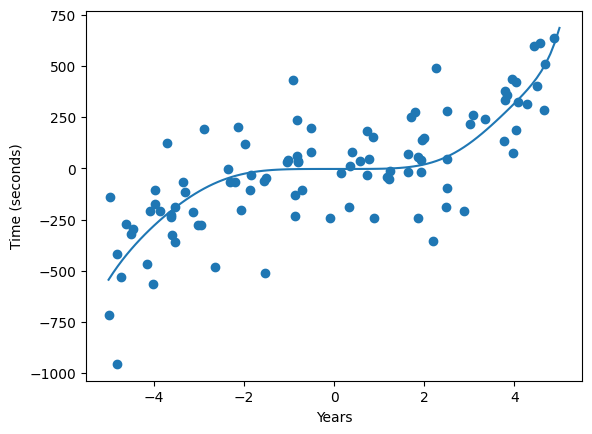

In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

poly_order = 10 

X_train = make_polynomial(x, poly_order) # construct polynomial matrix on training data
#print(X_train)

#print("stop")
'''
x_test = np.linspace(1880, 2020, 100).reshape(-1,1) # generate x_test for plotting

x_test = transform(x_test)
'''

x_test = np.linspace(-5, 5, 100).reshape(-1,1)

X_test = make_polynomial(x_test, poly_order) # construct polynomial matrix on x_test

#print(X_test)

ridge = Ridge() # call ridge model

#alphas = np.logspace(-6, 6, 50) # set out search grid for alpha
parameters = {'alpha': np.linspace(1, 10, 20)}


grid_search = GridSearchCV(ridge, 
                          param_grid={'alpha': alphas},
                          cv=5,
                          scoring='neg_mean_squared_error') # Define CV on the search grid to define alpha



grid_search.fit(X_train, t)

best_ridge = grid_search.best_estimator_

t_pred = best_ridge.predict(X_test)
... # Fit training data



plt.plot(x_test, t_pred)
... # plot the model
plt.scatter(x,t) # draw a scatter plot
plt.xlabel('Years') # always label x&y-axis
plt.ylabel('Time (seconds)') # always label x&y-axis

### Task 6 Practice linear regression with RBF. 

Write you own function to construct the design matrix with RBF

$$ h_k(x) = \exp \left( -\frac{ (x-\mbox{center}[k]) ^2}{2\mbox{width}}  \right)$$

In [ ]:
def make_rbf(x, center, width):  # again np.hstack is very helpful
    ...
    return(X)

#### Task 6.2 Construct  the design matrix with $x$ itself as the center parameter
Start with `width = 10` and test different values

In [ ]:
center = x 
width = 10
X_rbf = make_rbf(x, center, width)
X_rbf.shape

#### Task 6.2 Fit a linear regression model with X constructed by RBF

In [ ]:
...
...
plt.scatter(x,t) # draw a scatter plot
plt.xlabel('t') # always label x&y-axis
plt.ylabel('x') # always label x&y-axis